#### IMPORTING LIBRARIES

In [16]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sb
import folium
# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Image processing
from scipy.ndimage import convolve

# Geospatial
from shapely.geometry import Point, Polygon
import xarray as xr
import zarr # Not referenced, but required for xarray
import rasterio
import rasterio.features
import rioxarray as rio
import contextily as cx

# For TerraClimate
import fsspec

# Import Planetary Computer
import stackstac
import pystac
import pystac_client
import planetary_computer

# Other
import os
import gc
import zipfile

# Folder to store extracted files
storage_path = './output/'
if not os.path.exists(storage_path):
    os.mkdir(storage_path)

# Path to data folder with provided material
data_path = '/Users/seyi/Documents/WLV/project/JUPYTER/DATA/'

In [13]:
plt.style.use('ggplot')

## Loading Labelled Frog Data

Before we can build our model, we need to load in the response variable. To do this, we first need to unzip the training data and store it on our machine. Then we can write a function that abstracts the loading process, with the option of providing a bounding box to only take those occurrences within a region of interest.


In [5]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'training_data/')
    with zipfile.ZipFile(data_path+'GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path+'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'./training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

In [6]:
all_frog_data = get_frogs(data_path+'training_data/occurrence.txt')
all_frog_data.sample(10, random_state=120)

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
183952,1637117587,1998-09-13,Australia,Australia,South Australia,-34.894560,138.683230,Crinia Signifera
154724,3108952757,2019-09-21,Australia,Australia,New South Wales,-34.689881,150.611321,Litoria Fallax
20570,3463478049,2020-06-17,Australia,Australia,New South Wales,-33.778526,151.261454,Crinia Signifera
41643,3463698372,2020-05-30,Australia,Australia,New South Wales,-33.928700,151.260000,Crinia Signifera
50067,3463710581,2020-10-25,Australia,Australia,Queensland,-26.673391,152.886254,Litoria Fallax
8248,3463580061,2019-11-17,Australia,Australia,Queensland,-27.274100,152.073000,Litoria Fallax
35371,3463604130,2020-06-19,Australia,Australia,New South Wales,-33.755234,150.615838,Crinia Signifera
87394,2806222280,2010-12-01,Australia,Australia,New South Wales,-33.837995,151.074188,Crinia Signifera
183744,1637102103,1996-09-09,Australia,Australia,South Australia,-35.024980,138.812710,Crinia Signifera
149528,1654478357,2010-01-23,Australia,Australia,Queensland,-24.527600,151.470820,Litoria Fallax


In [4]:
all_frog_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193791 entries, 0 to 193790
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   gbifID            193791 non-null  int64         
 1   eventDate         185026 non-null  datetime64[ns]
 2   country           193791 non-null  object        
 3   continent         193791 non-null  object        
 4   stateProvince     193099 non-null  object        
 5   decimalLatitude   193791 non-null  float64       
 6   decimalLongitude  193791 non-null  float64       
 7   species           193791 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 11.8+ MB


In [5]:
all_frog_data.groupby('country')['species'].value_counts()

country             species                  
Angola              Xenopus Laevis                    2
Australia           Crinia Signifera             126657
                    Litoria Fallax                47332
                    Crinia Glauerti                9393
                    Ranoidea Australis             4097
                    Austrochaperina Pluvialis       541
Belize              Agalychnis Callidryas            21
Botswana            Chiromantis Xerampelina          37
                    Xenopus Laevis                    4
Colombia            Dendrobates Auratus             135
Costa Rica          Agalychnis Callidryas          1234
                    Dendrobates Auratus            1024
Eswatini            Chiromantis Xerampelina          38
                    Xenopus Laevis                   24
Guatemala           Agalychnis Callidryas            30
Honduras            Agalychnis Callidryas           144
Lesotho             Xenopus Laevis                   17
Ma

The training dataset contains occurrences for neighbouring countries in Central America and Africa, our interest for this challenge is Australia, Costa Rica, and South Africa. 

In [11]:
# Take only Australia, Costa Rica, and South Africa
frog_data = all_frog_data[all_frog_data.country.str.contains('Australia|Costa Rica|South Africa|Zimbabwe')]

In [7]:
frog_data[frog_data['country']=='South Africa'].decimalLatitude.max()

-22.230311

In [8]:
frog_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191733 entries, 0 to 193783
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   gbifID            191733 non-null  int64         
 1   eventDate         183172 non-null  datetime64[ns]
 2   country           191733 non-null  object        
 3   continent         191733 non-null  object        
 4   stateProvince     191248 non-null  object        
 5   decimalLatitude   191733 non-null  float64       
 6   decimalLongitude  191733 non-null  float64       
 7   species           191733 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 13.2+ MB


In [9]:
frog_data[frog_data['country'] == 'Australia'].groupby('stateProvince')[
    'species'].value_counts()


stateProvince                 species                  
Australian Capital Territory  Crinia Signifera              3385
                              Litoria Fallax                   6
Capitol Territory             Crinia Signifera                48
Jervis Bay Territory          Crinia Signifera                 2
New South Wales               Crinia Signifera             63488
                              Litoria Fallax               35984
New south wales               Crinia Signifera                16
                              Litoria Fallax                   5
Northern Territory            Ranoidea Australis            2822
                              Litoria Fallax                   1
Queensland                    Litoria Fallax               11074
                              Crinia Signifera              1347
                              Austrochaperina Pluvialis      541
                              Ranoidea Australis             431
                              Crin

In [10]:
print(frog_data[frog_data['country'] == 'Australia'].groupby('stateProvince')[
    'decimalLongitude'].min())
print('\n')
print(frog_data[frog_data['country'] == 'Australia'].groupby('stateProvince')[
    'decimalLongitude'].max())


stateProvince
Australian Capital Territory    148.771000
Capitol Territory               149.130646
Jervis Bay Territory            150.707778
New South Wales                 141.045033
New south wales                 148.467900
Northern Territory              129.006000
Queensland                      138.000000
South Australia                 132.720000
Tasmania                        143.839421
Victoria                        140.967580
Western Australia               114.916670
Western australia               115.804791
Name: decimalLongitude, dtype: float64


stateProvince
Australian Capital Territory    150.762870
Capitol Territory               149.130646
Jervis Bay Territory            150.757783
New South Wales                 153.636442
New south wales                 152.834600
Northern Territory              137.850000
Queensland                      153.554734
South Australia                 140.995120
Tasmania                        148.356592
Victoria                    

In [11]:
print(frog_data[frog_data['country'] == 'Australia'].groupby('stateProvince')[
    'decimalLatitude'].min())
print('\n')
print(frog_data[frog_data['country'] == 'Australia'].groupby('stateProvince')[
    'decimalLatitude'].max())

stateProvince
Australian Capital Territory   -35.890500
Capitol Territory              -35.271357
Jervis Bay Territory           -35.159439
New South Wales                -37.502812
New south wales                -36.365200
Northern Territory             -25.700000
Queensland                     -34.650000
South Australia                -38.056430
Tasmania                       -43.766700
Victoria                       -39.711670
Western Australia              -35.096100
Western australia              -32.152220
Name: decimalLatitude, dtype: float64


stateProvince
Australian Capital Territory   -35.124508
Capitol Territory              -35.271357
Jervis Bay Territory           -35.151111
New South Wales                -28.159902
New south wales                -29.668028
Northern Territory             -11.120000
Queensland                     -11.966660
South Australia                -31.425000
Tasmania                       -39.059400
Victoria                       -34.090100
Western 

In [8]:
# Define species colourmap
species_colourmap = {species:colour['color'] for species, colour in zip(all_frog_data.species.value_counts().index, cycle(plt.rcParams['axes.prop_cycle']))}

def plot_species(fig, ax, frog_data, region_name, colourmap=None):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)
    # Colour cycle to ensure colors match in both plots
    if colourmap is None:
        colourmap = {species:colour['color'] for species, colour in zip(frog_data.species.value_counts().index, cycle(plt.rcParams['axes.prop_cycle']))}
    for i in range(len(bar_data)):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(colourmap[species_name])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=colourmap[species_name]
        )
    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, alpha=0.5) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    
def plot_barchart(bar_data, ax, colourmap=None, bar_params={}):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    if colourmap is None:
        prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
        colourmap = {spec:col['color'] for spec, col in zip(bar_data.index, prop_cycle)}
    for i in range(len(bar_data)):
        var_name = bar_data.index[i]
        barchart[i].set_color(colourmap[var_name])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

In [14]:

def plot_species_dist(countries):
    country = countries
    frog_country = frog_data[frog_data['country'] == country]
    frog_country['year'] =frog_country['eventDate'].dt.year
    frog_country['species_count']=frog_country.groupby('year')['species'].transform('count')
    df = frog_country
    #colour_palette = "terrain"
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    sb.countplot(df.species,ax=ax[0]).set(
        title='Distribution of frog species in' +' '+ country)
    ax[0].set_xticklabels(list(frog_country.species.unique()), rotation=45)
    sb.lineplot(x='year', y='species_count', data=df, ax=ax[1],hue = 'species').set(
        title='Count of frog species in' +' '+country +' '+'Per Year')
    ax[2]=sb.scatterplot(data = df, x='decimalLongitude', y='decimalLatitude', 
                  hue = 'species', legend = False)
    ax[2].set_title(f"Distribution of frog species in {country}")
    cx.add_basemap(ax[2],crs={'init':'epsg:4326'}, alpha=0.5)

Below, we can visualise the frog species distribution of each country. 

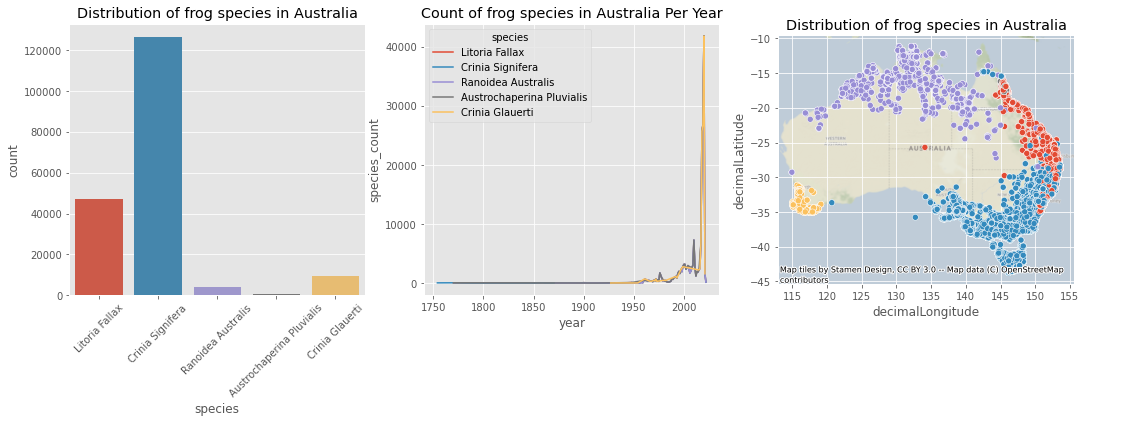

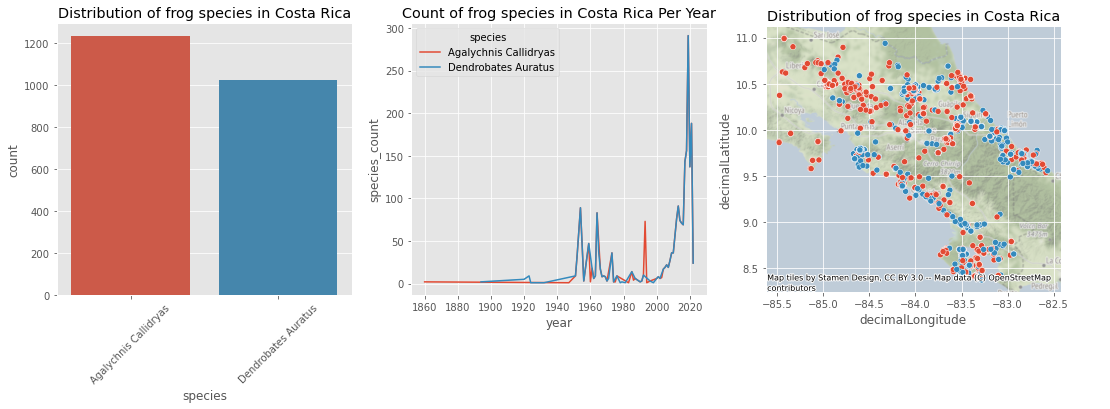

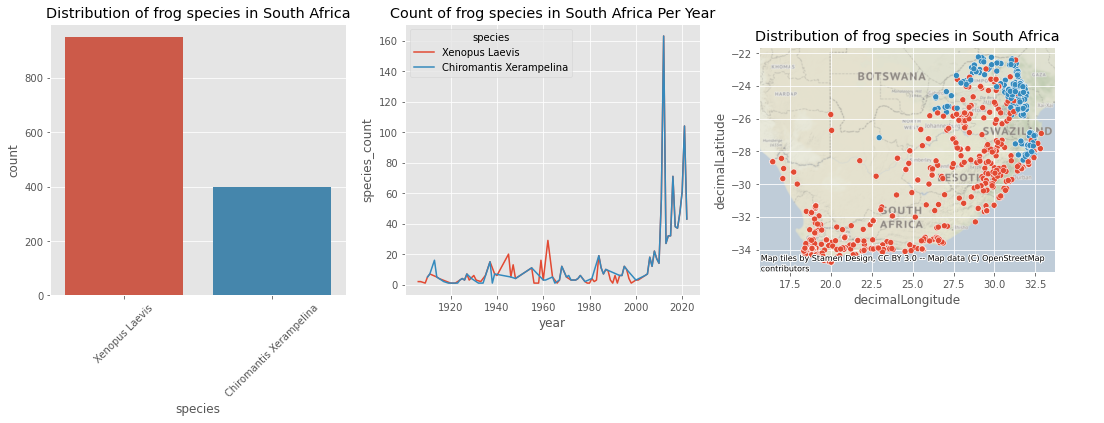

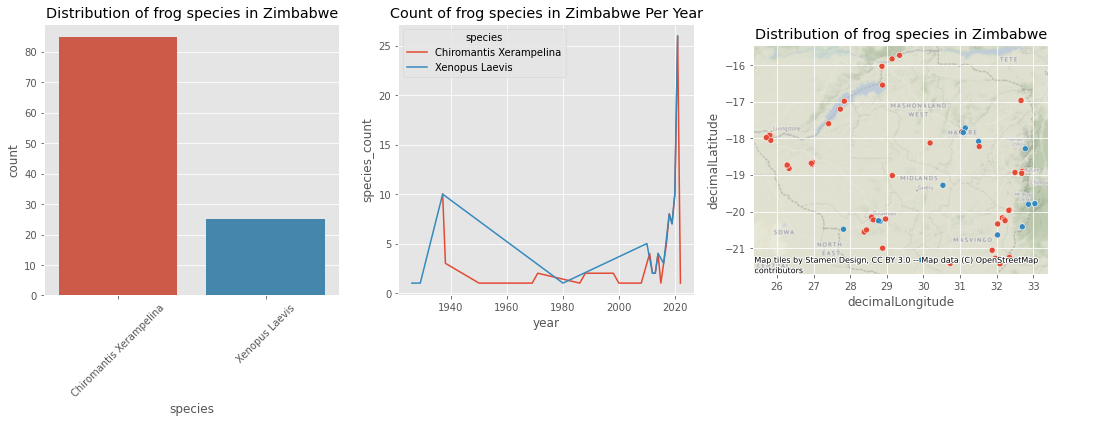

In [15]:
for country in frog_data.country.unique():
    plot_species_dist(country)

1. The count plot above shows the count of frog species across Australia, Costa Rica and South Africa.
2. From the lineplot, we can observe the years in which there were increase in the occurences of some the frog species in the different countries.
3. The map shows the distribution of the different frog species per country

In [17]:
# Plotting functions
def plotDot(point, folium_map, species_colours):
    folium.CircleMarker(
        location=[point.decimalLatitude, point.decimalLongitude],
        radius=10,
        stroke=False,
        weight=5,
        fill=True,
        fillOpacity=1.0,
        opacity=1.0,
        color=species_colours[point.species]
    ).add_to(folium_map)
    
#create a map
frog_map = folium.Map(prefer_canvas=True)

# plot 1000 points from each country
(
     frog_data[frog_data.country == 'Australia'].sample(3000, random_state=420).append(
         frog_data[frog_data.country == 'Costa Rica'].sample(3000, random_state=420).append(
             frog_data[frog_data.country == 'South Africa'].sample(3000, random_state=420).append(
                 frog_data[frog_data.country == 'Zimbabwe'].sample(110, random_state=420)
             )
         )
     )
).apply(
    plotDot, axis = 1, args=(frog_map, species_colourmap)
)

#Set the zoom to the maximum possible
frog_map.fit_bounds(frog_map.get_bounds())
#Lat lon on click
frog_map.add_child(folium.LatLngPopup())
#Save the map to an HTML file
frog_map.save(storage_path+'frog_map_training.html')
frog_map

In [18]:
print(frog_data[frog_data['country'] == 'Australia'].groupby('stateProvince')[
    'decimalLatitude'].min())
print('\n')
print(frog_data[frog_data['country'] == 'Australia'].groupby('stateProvince')[
    'decimalLatitude'].max())


stateProvince
Australian Capital Territory   -35.890500
Capitol Territory              -35.271357
Jervis Bay Territory           -35.159439
New South Wales                -37.502812
New south wales                -36.365200
Northern Territory             -25.700000
Queensland                     -34.650000
South Australia                -38.056430
Tasmania                       -43.766700
Victoria                       -39.711670
Western Australia              -35.096100
Western australia              -32.152220
Name: decimalLatitude, dtype: float64


stateProvince
Australian Capital Territory   -35.124508
Capitol Territory              -35.271357
Jervis Bay Territory           -35.151111
New South Wales                -28.159902
New south wales                -29.668028
Northern Territory             -11.120000
Queensland                     -11.966660
South Australia                -31.425000
Tasmania                       -39.059400
Victoria                       -34.090100
Western 

In [46]:
-35.096100+ 5

-30.0961


### Spatial sampling

Due to the high resolution of the satellite data we aim to use in this challenge, the memory required to load in data for any significant region quickly becomes overbearing. Thus, it is only feasible to load in satellite data for small regions at a time.


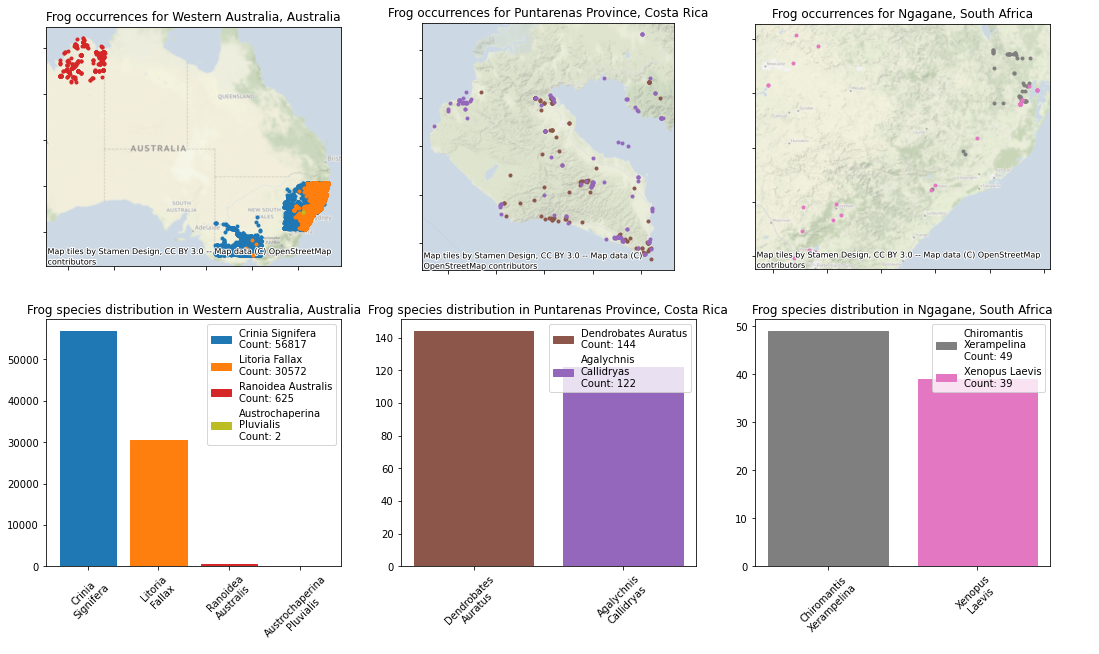

In [48]:
training_regions = {
    'Australia':[
        {'title': "Queensland, Australia",
         'bbox': (148.554734, -34.650000,  153.554734, -29.65)},
        {'title': "New South Wales, Australia",
         'bbox': (141.045033, -37.502812, 146.045033, -32.502812)},
        {'title': "Western Australia, Australia",
         'bbox': (123.985000, -18.894444, 128.985000, -13.894444)}
    ],
    'Costa Rica':[
        {'title':"Puntarenas Province, Costa Rica",
        'bbox':(-83.75,8.35,-83.25,8.85)}
    ],
    'South Africa':[
        {'title':"Hluhluwe, South Africa",
        'bbox':(32.00,-28.1,32.50,-27.6)},
        {'title': "Midmar Dam Nature Reserve, South Africa",
         'bbox':(30.19, -29.52,30.69, -29.02)},
        {'title': "Eshowe, South Africa",
         'bbox': (31.46, -28.90, 31.96, -28.40)},
        {'title': "Ngagane, South Africa",
         'bbox': (29.95, -27.93, 30.45, -27.43)}
    ]#,
    #'Zimbabwe':[
    #    {'title':"Bulawayo, Zimbabwe",
    #    'bbox':(34.00,-18.68,34.50,-18.18)}
    #]'''
}
training_data = pd.DataFrame()

fig, ax = plt.subplots(2, 3, figsize=(18, 10))
for i, (cnt, boxes) in enumerate(training_regions.items()):
    plot_data = pd.DataFrame()
    for box in boxes:
        plot_data = plot_data.append(filter_bbox(frog_data, box['bbox']))
    training_data = training_data.append(plot_data)
    plot_species(fig, ax[:, i], plot_data, box['title'], colourmap=species_colourmap)
plt.show()

In [21]:
for cnt, regions in training_regions.items():
    print(f"Obtaining data for {cnt}")
    for i, region in enumerate(regions):
        print(i,region)

Obtaining data for Australia
0 {'title': 'Queensland, Australia', 'bbox': (138.0, -34.65, 143.0, -29.65)}
1 {'title': 'New South Wales, Australia', 'bbox': (141.045033, -37.502812, 146.045033, -32.502812)}
2 {'title': 'Western Australia, Australia', 'bbox': (114.91667, -35.0961, 119.91667, -30.0961)}
Obtaining data for Costa Rica
0 {'title': 'Puntarenas Province, Costa Rica', 'bbox': (-83.75, 8.35, -83.25, 8.85)}
Obtaining data for South Africa
0 {'title': 'Hluhluwe, South Africa', 'bbox': (32.0, -28.1, 32.5, -27.6)}
1 {'title': 'Midmar Dam Nature Reserve, South Africa', 'bbox': (30.19, -29.52, 30.69, -29.02)}
2 {'title': 'Eshowe, South Africa', 'bbox': (31.46, -28.9, 31.96, -28.4)}
3 {'title': 'Ngagane, South Africa', 'bbox': (29.95, -27.93, 30.45, -27.43)}


From the charts above, we observe the species distribution for the different countries. There are 5 different species accross the different locations in Australia and two distinct species each for Costa Rica and South Africa. The locations were select so that samples for all 9 species are included.

### Class balancing

The barchat belows shows the class imbalance of the frog species. This bias will be addressed in some capacity before model training to prevent the model becoming biased towards the more common species.


Text(0.5, 1.0, 'Unbalanced training set')

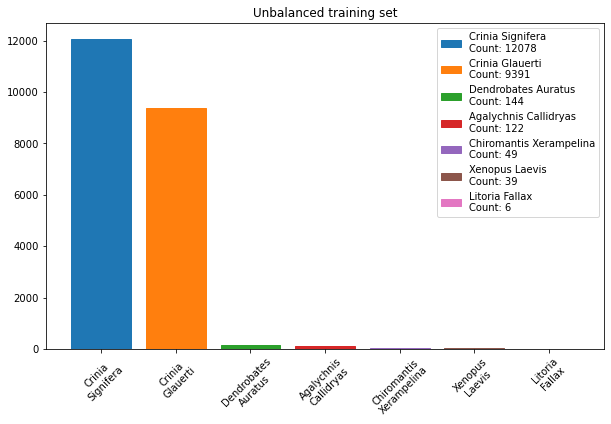

In [22]:
unbalanced_bar_data = training_data.species.value_counts()
# Bar charts
fig, ax = plt.subplots(figsize = (10, 6), sharey=True, sharex=True)
#balanced_bar_data = balanced_frogs.species.value_counts()
plot_barchart(unbalanced_bar_data, ax, bar_params={})
ax.set_title('Unbalanced training set')

In [23]:
training_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
80,1100369337,1982-11-23,Australia,Australia,South Australia,-33.833,138.600,Crinia Signifera
502,1100369263,1982-11-23,Australia,Australia,South Australia,-33.833,138.600,Crinia Signifera
752,1100534992,1976-01-04,Australia,Australia,South Australia,-34.633,138.866,Crinia Signifera
882,1100496531,NaT,Australia,Australia,South Australia,-34.483,139.000,Crinia Signifera
3159,1100534994,1976-01-04,Australia,Australia,South Australia,-34.633,138.866,Crinia Signifera


In [24]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21829 entries, 80 to 168764
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gbifID            21829 non-null  int64         
 1   eventDate         20468 non-null  datetime64[ns]
 2   country           21829 non-null  object        
 3   continent         21829 non-null  object        
 4   stateProvince     21790 non-null  object        
 5   decimalLatitude   21829 non-null  float64       
 6   decimalLongitude  21829 non-null  float64       
 7   species           21829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 1.5+ MB


In [25]:
#Reseting Index and creating key
training_data = training_data.reset_index(drop=True).assign(key = lambda x: x.index)
training_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,key
0,1100369337,1982-11-23,Australia,Australia,South Australia,-33.833,138.600,Crinia Signifera,0
1,1100369263,1982-11-23,Australia,Australia,South Australia,-33.833,138.600,Crinia Signifera,1
2,1100534992,1976-01-04,Australia,Australia,South Australia,-34.633,138.866,Crinia Signifera,2
3,1100496531,NaT,Australia,Australia,South Australia,-34.483,139.000,Crinia Signifera,3
4,1100534994,1976-01-04,Australia,Australia,South Australia,-34.633,138.866,Crinia Signifera,4


In [26]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21829 entries, 0 to 21828
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gbifID            21829 non-null  int64         
 1   eventDate         20468 non-null  datetime64[ns]
 2   country           21829 non-null  object        
 3   continent         21829 non-null  object        
 4   stateProvince     21790 non-null  object        
 5   decimalLatitude   21829 non-null  float64       
 6   decimalLongitude  21829 non-null  float64       
 7   species           21829 non-null  object        
 8   key               21829 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 1.5+ MB


## Predictor Variables

### TerraClimate


In [27]:
def get_terraclimate(bbox, filename=None, metrics={'mean':{'fn':np.nanmean,'params':{}}}, 
                     time_slice=None, assets=None, features=None, interp_dims=None, verbose=False):
    """Returns terraclimate metrics for a given area (or None if filename specified), allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    filename -- string or None. If None, will save result to geotiff. 
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    #Open Zarr
    #Zarr is a format for the storage of chunked, compressed, N-dimensional arrays.
    data = xr.open_zarr(store, chunks= {},consolidated= True)
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    #Convert dataset to xarray
    data = data.rename(lat='y', lon='x').to_array().compute()
            
    # Calculate metrics
    combined_data = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        sum_data = sum_data.assign_coords(band = [band+'_'+name for band in sum_data.band.values])
        combined_data.append(sum_data)
        
    # Combine metrics
    combined_data = xr.concat(combined_data, dim='band')
    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
        
    if filename is not None:
        save_to_geotiff(combined_data, filename, bbox)
        return None
    
    return combined_data

### Sentinel-2

In [28]:
def split_bbox(bbox, n_x, n_y):
    """Splits bounding box into n_x columns and n_y rows"""
    lons = np.linspace(bbox[0],bbox[2], n_x+1)
    lats = np.linspace(bbox[1],bbox[3], n_y+1)
    boxes = []
    for i in range(len(lons)-1):
        for j in range(len(lats)-1):
            boxes.append((lons[i], lats[j], lons[i+1], lats[j+1]))
    return boxes

def scene_overlap(signed_item, bbox_poly):
    """Returns the polygon of the bounding box not covered by the scene"""
    scene_poly = Polygon(signed_item['geometry']['coordinates'][0])
    return bbox_poly.difference(scene_poly)

def get_optimal_coverage(signed_items, bbox, sortby='s2:nodata_pixel_percentage',
                         reverse=False, target_coverage=1.0, scenes_per_hit=1, verbose=False):
    signed_items = sorted(signed_items, key=lambda x: x['properties'][sortby], reverse=reverse)

    bbox_poly = Polygon([
        [bbox[0], bbox[1]],
        [bbox[0], bbox[3]],
        [bbox[2], bbox[3]],
        [bbox[2], bbox[1]],
        [bbox[0], bbox[1]]
    ])
    take_items = []
    remaining_area = Polygon(bbox_poly)
    remaining_area_prev = Polygon(bbox_poly)
    for i, item in enumerate(signed_items):
        remaining_area = Polygon(scene_overlap(item, remaining_area_prev))
        # If item hits new area, take it.
        new_coverage = remaining_area_prev.difference(remaining_area).area/bbox_poly.area
        if new_coverage > 0.0:
            take_items.append(item)
            n_scenes = 1
        else:
            if n_scenes < scenes_per_hit:
                take_items.append(item)
                n_scenes += 1

        # If remaining area is less than the <optimise_coverage> threshold, break
        total_coverage = 1 - remaining_area.area/bbox_poly.area
        if total_coverage >= target_coverage: 
            for j in range(1, scenes_per_hit+1):
                if i+j < len(signed_items):
                    take_items.append(signed_items[i+j])
            if verbose:
                print(f'Covered {round((total_coverage)*100, 2)}% with {len(take_items)} scenes')
                print(f'Searched {min(i+scenes_per_hit, len(signed_items))} scenes')
            break
        remaining_area_prev = Polygon(remaining_area)
    else:
        print(f'Only covered {round((total_coverage)*100, 2)}% with {len(take_items)} scenes')
        print(f'Consider refining query parameters')
    signed_items = take_items
    
    return signed_items

### Elevation (Copernicus DEM)


In [29]:
def slope_pct(dem, resolution):
    # Kernel for rate of elevation change in x-axis.
    dx_kernel = np.array([[1, 0, -1],
                          [2, 0, -2],
                          [1, 0, -1]])
    # Kernel for rate of elevation change in y-axis.
    dy_kernel = np.array([[1, 2, 1],
                          [0, 0, 0],
                          [-1, -2, -1]])
    # Rate of change calculations for each axis.
    dx = convolve(dem, dx_kernel) / (8 * resolution)
    dy = convolve(dem, dy_kernel) / (8 * resolution)
    # Return rise/run * 100 for slope percent.
    return np.sqrt(np.square(dx) + np.square(dy)) * 100

### Land Cover (Esri)

The Esri Land Cover dataset contains categorical labels for each pixel on the type of terrain. The categories are encoded as integers from 1 to 10, and so will need to be translated to make sense for our model. We will translate the landcover values into one-hot encoding, where each category will have a binary mask of presence and absense. To do this, we define the categorical mapping below, taken from the [Esri Land Cover documentation.](https://planetarycomputer.microsoft.com/dataset/io-lulc)

In [30]:
landcover_mapper = {
    1:  'lc_water', 
    2:  'lc_trees', 
    3:  'lc_grass',
    4:  'lc_flooded_vegetation', 
    5:  'lc_crops',
    6:  'lc_scrub', 
    7:  'lc_urban', 
    8:  'lc_bare_soil',
    9:  'lc_snow_ice', 
    10: 'lc_clouds'
}

### Surface Water (JRC)


In [31]:
JRC_transitions_mapper = {
    1:  "JRC_tr_permanent", 
    2:  "JRC_tr_new_permanent", 
    3:  "JRC_tr_lost_permanent", 
    4:  "JRC_tr_seasonal", 
    5:  "JRC_tr_new_seasonal", 
    6:  "JRC_tr_lost_seasonal", 
    7:  "JRC_tr_seasonal_to_permanent", 
    8:  "JRC_tr_permanent_to_seasonal", 
    9:  "JRC_tr_ephemeral_permanent", 
    10: "JRC_tr_ephemeral_seasonal"
}

### Loading variables


In [32]:
# Function to access the planetary computer
def get_pc(product, bbox, filename=None, assets={"image/tiff"}, resolution=10, 
           pc_query=None, date_range=None, na_val=None, optimise_coverage_params=None, verbose=True):
    """Return the median mosaic xarray of a specified planetary computer product for a given location
    
    Attributes:
    product -- string representing the planetary computer product
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    assets -- list of assets to take from the product
    resolution -- resolution in meters
    pc_query -- dictionary of arguments to pass to the planetary computer
    date_range -- string representing the date range of the query e.g. '2020-01-01/2020-12-31'
    na_val -- the value representing na values in the dataset. Will be ignored in median calculation
    filename -- string or None. If None, will save result to geotiff.
    """
    # Query the planetary computer
    #STAC - Spatial Temporal Asset Catalogue
    #STAC is a standardized way to expose collections of spatial temporal data.
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = stac.search(
        bbox=bbox,
        datetime=date_range,
        collections=[product],
        limit=500,  # fetch items in batches of 500
        query=pc_query
    )
    items = list(search.get_items())
    print(f'{len(items)} scenes touching region') if verbose else None
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]
    
    if optimise_coverage_params is not None:
        signed_items = get_optimal_coverage(signed_items, bbox, verbose=verbose, **optimise_coverage_params)
    
    # Define the scale according to our selected crs, so we will use degrees
    scale = resolution / 111320.0 # degrees per pixel for crs=4326 
        
    # Stack up the items returned from the planetary computer
    data = (
        stackstac.stack(
            signed_items,
            epsg=4326, # Use common Lat-Lon coordinates
            resolution=scale, # Use degrees for crs=4326
            bounds_latlon = bbox,
            resampling=rasterio.enums.Resampling.average, # Average resampling method (only required when resolution >10)
            chunksize=4096,
            assets=assets
        )
    )
    
    if na_val is not None:
        data = data.where(lambda x: x != na_val, other=np.nan)
        
    # Median Composite
    median = data.median(dim="time", skipna=True)
    
    # Rename bands of those with only one band (which otherwise defaults to generic 'data')
    if median.shape[0] == 1:
        median = median.assign_coords(band=[product])
    
    if filename is not None:
        save_to_geotiff(median, filename, bbox)
        return None
    
    return median


In [33]:
def join_frogs(bbox, data, frogs, verbose=False):
    intersecting_frogs = (
        frogs
        [lambda x: 
         (x.decimalLongitude >= bbox[0]) &
         (x.decimalLatitude >= bbox[1]) &
         (x.decimalLongitude <= bbox[2]) &
         (x.decimalLatitude <= bbox[3])
        ]
    )
    if len(intersecting_frogs) > 0:
        print('merging frogs') if verbose else None
        frogs = frogs.merge(
            (
                data
                .sel(
                    x=xr.DataArray(intersecting_frogs.decimalLongitude, dims="key", coords={"key": intersecting_frogs.key}), 
                    y=xr.DataArray(intersecting_frogs.decimalLatitude, dims="key", coords={"key": intersecting_frogs.key}),
                    method="nearest"
                )
                .to_dataframe()
                .assign(val = lambda x: x.iloc[:, -1])
                [['val']]
                .reset_index()
                .drop_duplicates()
                .pivot(index="key", columns="band", values="val")
                .reset_index()
            ),
            on = ['key'],
            how = 'inner'
        )[list(data.band.values) + ['key']]
        return frogs
    else:
        return pd.DataFrame(columns=list(data.band.values) + ['key'])
        
def get_and_join_data(products, bbox, all_frogs, split_sen=(10, 10), verbose=False):
    """collect and download all products"""
    for i, (product, params) in enumerate(products.items()):
        print(f'loading {product}')
        if product == 'sentinel-2-l2a':
            sen_frogs = pd.DataFrame()
            for box_num, box in enumerate(split_bbox(bbox, split_sen[0], split_sen[1])):
                print(f'fetching box {box_num+1} of {split_sen[0]*split_sen[1]}') if verbose else None
                data = get_pc(product, box, verbose=verbose, **params)
                sen_frogs = sen_frogs.append(join_frogs(box, data, all_frogs))
            all_frogs = all_frogs.merge(
                sen_frogs,
                on='key',
                how='left'
            )
            del sen_frogs
        else:
            # Interpolate the weather data to 10m resolution
            if product == 'terraclimate':
                data = get_terraclimate(bbox, verbose=verbose, **params)
            else:
                data = get_pc(product, bbox, verbose=verbose, **params)
            # Calculate the gradient of the elevation data
            if product == 'cop-dem-glo-30':
                data_elevation = data.squeeze().drop("band")
                slope_vals = slope_pct(data_elevation, products[product]['resolution'])
                data_slope = xr.DataArray(
                    np.expand_dims(slope_vals, 0),
                    coords=dict(
                        band=['gradient'],
                        y=data_elevation.y,
                        x=data_elevation.x
                    )
                )
                data = xr.concat((data, data_slope), dim='band')
                # remove elevation data from memory
                del data_slope, data_elevation, slope_vals
            all_frogs = all_frogs.merge(
                join_frogs(bbox, data, all_frogs, verbose=verbose),
                on='key',
                how='left'
            )
    return all_frogs

In [125]:
%%time

resolution = 100 # in meters. Finest = 10m

# Define products and query parameters for the planetary computer
products = {
    # Land Cover
    "io-lulc":{
        "resolution":resolution
    },
    # Elevation
    "cop-dem-glo-30":{
        "resolution":resolution
    },
    # Water extent data
    'jrc-gsw':{
        "resolution":resolution
    },
    # Sentinel-2 Spectral Band data
    'sentinel-2-l2a':{
        "resolution":resolution,
        'assets':["B04", "B03", "B02", "B08","B05","B11"], # Bands to take
        'pc_query':{
            "eo:cloud_cover": {"lt": 15} # Lower means clearer scenes, but may filter out all scenes for certain parts of the region.
        },
        'date_range':'2015-01-01/2020-12-31',
        # Take minimum scenes to cover entire area
        'optimise_coverage_params':{
            'sortby':'s2:nodata_pixel_percentage',
            'reverse':False,
            'target_coverage':1.0, # Proportion of scene to cover
            'scenes_per_hit':1 # With a few extra in case of clouds
        },
        'na_val':0
    },
    # Weather - might need to adjust x_dim, y_dim params to match dimensions of dataarrays above. Off by one errors common.
    "terraclimate":{
        'metrics':{
            'mean':{
                'fn':np.nanmean,
                'params':{}
            },
            'min':{
                'fn':np.nanmin,
                'params':{}
            },
            'max':{
                'fn':np.nanmax,
                'params':{}
            }
        },#'2015-01-01','2019-12-31'
        'time_slice':('2015-01-01','2020-01-01'),
        'assets':['q','vap','tmax', 'tmin', 'ppt', 'soil'],
        'features':['q_mean','vap_mean','tmax_max', 'tmax_mean', 'tmin_min', 'tmin_mean', 'ppt_mean', 'soil_mean']
    }
}

product_names={"cop-dem-glo-30":'elevation', "io-lulc":'landcover', 'jrc-gsw':'surface_water', 'sentinel-2-l2a':'sentinel-2'} 

# Load in data - comment out if already run
model_data = pd.DataFrame()
for cnt, regions in training_regions.items():
    print(f"Obtaining data for {cnt}")
    for i, region in enumerate(regions):
        print(f"{region['title']} ({i+1} of {len(regions)})")
        model_data = model_data.append(
            get_and_join_data(
                products, region['bbox'], filter_bbox(training_data, region['bbox']),
                split_sen=(1, 1), verbose=True
            )
        )
model_data = model_data.rename(columns=product_names)
model_data.to_csv(storage_path+f'training_{resolution}m.csv', index=None)

# Load in from file
model_data = pd.read_csv(storage_path+f'training_{resolution}m.csv')

# Display percentage of null values for each variable by country
print('Percentage of null values for each variable by country:')
display(
    np.divide(
        model_data.isna().join(model_data[['country']], lsuffix='_').groupby('country').sum(), 
        model_data.groupby('country').count()[['gbifID']]
    ).drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species', 'country_', 'key'], 1)*100
)

# Drop rows with NAs
model_data = model_data.dropna()
print('Model data:')
display(model_data)

Obtaining data for Australia
Port Macquarie, Australia (1 of 5)
loading io-lulc
2 scenes touching region
merging frogs
loading cop-dem-glo-30
1 scenes touching region
merging frogs
loading jrc-gsw
1 scenes touching region
merging frogs
loading sentinel-2-l2a
fetching box 1 of 1
446 scenes touching region
Covered 100.0% with 3 scenes
Searched 104 scenes
loading terraclimate
Loading data
Calculating mean
Calculating min
Calculating max
merging frogs
Braeside, Australia (2 of 5)
loading io-lulc
2 scenes touching region
merging frogs
loading cop-dem-glo-30
1 scenes touching region
merging frogs
loading jrc-gsw
1 scenes touching region
merging frogs
loading sentinel-2-l2a
fetching box 1 of 1
121 scenes touching region
Covered 100.0% with 2 scenes
Searched 1 scenes
loading terraclimate
Loading data
Calculating mean
Calculating min
Calculating max
merging frogs
Darwin, Australia (3 of 5)
loading io-lulc
2 scenes touching region
merging frogs
loading cop-dem-glo-30
2 scenes touching region
mer

,continent,stateProvince,landcover,elevation,gradient,change,extent,occurrence,recurrence,seasonality,...,B05,B11,q_mean,vap_mean,tmax_max,tmax_mean,tmin_min,tmin_mean,ppt_mean,soil_mean
country,,,,,,,,,,,,,,,,,,,,,
Australia,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.020519,0.020519,0.020519,0.020519,0.020519,0.020519,0.020519,0.020519
Costa Rica,0.0,11.544228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.599700,0.599700,0.599700,0.599700,0.599700,0.599700,0.599700,0.599700
South Africa,0.0,20.454545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Zimbabwe,0.0,39.130435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.695652,8.695652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Model data:


,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,key,landcover,...,B05,B11,q_mean,vap_mean,tmax_max,tmax_mean,tmin_min,tmin_mean,ppt_mean,soil_mean
0,2818667399,2014-01-16 13:30:00,Australia,Australia,New South Wales,-31.804450,152.728649,Litoria Fallax,0,4.0,...,1233.0,2149.0,11.549180,1.550574,30.199999,24.559999,6.6,14.015573,97.290164,108.478690
1,1071587460,2005-10-18 00:00:00,Australia,Australia,New South Wales,-31.458809,152.872052,Litoria Fallax,1,7.0,...,1598.0,2604.0,14.580328,1.571623,29.900000,24.469016,6.6,14.007377,103.298361,107.903280
2,2806337299,2020-04-14 00:00:00,Australia,Australia,New South Wales,-31.467921,152.873221,Crinia Signifera,2,7.0,...,950.0,1711.0,14.580328,1.571623,29.900000,24.469016,6.6,14.007377,103.298361,107.903280
3,1072127779,1995-01-06 00:00:00,Australia,Australia,New South Wales,-31.752803,152.585086,Litoria Fallax,3,2.0,...,2662.0,3474.0,12.155738,1.483295,30.400000,24.504917,6.1,13.377049,98.580328,114.418035
4,1072032944,2003-07-23 00:00:00,Australia,Australia,New South Wales,-31.592781,152.837717,Crinia Signifera,4,4.0,...,727.5,1370.5,14.324590,1.574197,30.099998,24.551475,7.0,14.182950,103.855738,107.381970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10517,3384687784,2021-08-24 06:52:00,Zimbabwe,Africa,Masvingo,-20.248165,32.230687,Chiromantis Xerampelina,10517,6.0,...,2426.0,4520.0,5.700000,1.844754,34.599998,30.400983,8.4,15.565082,42.378689,15.142623
10519,476538170,1938-01-08 00:00:00,Zimbabwe,Africa,Manicaland,-19.966670,32.333340,Chiromantis Xerampelina,10519,5.0,...,1634.0,3215.5,6.568852,1.844590,35.040001,30.521967,8.3,15.730655,41.704918,14.308197
10520,891114907,2012-12-30 10:08:24,Zimbabwe,Africa,Manicaland,-19.802221,32.870743,Xenopus Laevis,10520,7.0,...,12030.0,8431.0,40.459016,1.476328,25.900000,21.536721,7.6,12.299836,103.401639,63.654101
10523,1265266883,2010-09-30 00:00:00,Zimbabwe,Africa,Manicaland Province,-19.785310,33.045720,Xenopus Laevis,10523,8.0,...,1129.0,2211.0,70.052459,1.316508,22.400000,18.274098,6.4,10.466721,138.329508,86.190164


CPU times: user 5min 46s, sys: 1min 49s, total: 7min 36s
Wall time: 15min 37s


In [126]:
len(model_data)


9339

In [75]:
%%time
#Save to CSV
model_data.to_csv(storage_path+'model_data_csv', sep='\t')

CPU times: user 265 ms, sys: 13.2 ms, total: 278 ms
Wall time: 286 ms


In [113]:
%%time
#Read model Data from CSV
model_data = pd.read_csv(storage_path+'model_data_csv',sep='\t')

CPU times: user 47.9 ms, sys: 16.8 ms, total: 64.7 ms
Wall time: 68.4 ms


In [114]:
model_data.describe()

,Unnamed: 0,gbifID,decimalLatitude,decimalLongitude,key,landcover,elevation,gradient,change,extent,...,B11,q_mean,vap_mean,swe_mean,tmax_max,tmax_mean,tmin_min,tmin_mean,ppt_mean,soil_mean
count,8375.000000,8.375000e+03,8375.000000,8375.000000,8375.000000,8375.000000,8375.000000,8375.000000,8375.000000,8375.000000,...,8375.000000,8375.000000,8375.000000,8.375000e+03,8375.000000,8375.000000,8375.000000,8375.000000,8375.000000,8375.000000
mean,4583.931463,2.842517e+09,-30.482470,134.307158,4583.931463,4.716478,107.459298,5.473066,251.178687,0.011582,...,1969.234567,17.203913,1.464855,1.957426e-07,30.817356,23.908031,7.212193,12.853127,89.667220,100.731275
std,2834.151347,8.941319e+08,11.231420,39.854821,2834.151347,2.153447,129.139537,6.537728,14.102904,0.107001,...,772.216890,23.513451,0.571044,1.791339e-05,3.163468,4.946587,4.823185,4.799128,40.614871,69.811548
min,0.000000,4.765703e+08,-37.900000,-83.728644,0.000000,1.000000,0.000000,0.000000,55.000000,0.000000,...,112.000000,2.491803,0.906033,0.000000e+00,25.400000,16.546393,0.000000,6.342951,46.290164,3.401639
25%,2095.500000,1.988541e+09,-37.760300,131.147180,2095.500000,2.000000,15.209654,0.885049,253.000000,0.000000,...,1412.000000,5.185246,1.082295,0.000000e+00,28.799999,20.465409,4.000000,9.420164,61.747541,49.660656
50%,4192.000000,3.463463e+09,-37.504500,145.220075,4192.000000,5.000000,74.082161,3.230057,253.000000,0.000000,...,1842.000000,9.644262,1.110574,0.000000e+00,29.099998,20.789999,4.900000,10.364918,76.393443,69.144263
75%,7228.500000,3.463605e+09,-31.456743,145.434650,7228.500000,7.000000,142.336411,7.411679,253.000000,0.000000,...,2465.000000,22.060656,1.569492,0.000000e+00,33.770000,24.798360,7.200000,14.007377,103.298361,115.686887
max,9446.000000,3.469585e+09,8.831991,152.900000,9446.000000,8.000000,1553.022827,66.918785,253.000000,1.000000,...,8836.000000,169.439344,3.022099,1.639344e-03,37.799999,33.817540,20.279999,22.365573,282.388525,326.734432


### Recoding categorical variables

As mentioned above, the Land Cover data and the JRC data both contain categorical variables that need recoding for use in our model. The mappings are stored in `landcover_mapper` and `JRC_transitions_mapper` we defined earlier. Below we recode these variables into one-hot encoding, a binary mask for each class. This is necessary for certain models like logistic regression which we aim to use in this demonstration.

In [115]:
model_data = (
    model_data
    .merge(
        pd.get_dummies(
            model_data.landcover.astype(int).map(landcover_mapper)
        ).assign(key=model_data.key),
        on='key'
    )
    .drop("landcover", 1)
    .merge(
        pd.get_dummies(
            model_data.transitions.astype(int).map(JRC_transitions_mapper)
        ).assign(key=model_data.key),
        on='key'
    )
    .drop("transitions", 1)
)
model_data.head()

,Unnamed: 0,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,key,...,JRC_tr_ephemeral_permanent,JRC_tr_ephemeral_seasonal,JRC_tr_lost_permanent,JRC_tr_lost_seasonal,JRC_tr_new_permanent,JRC_tr_new_seasonal,JRC_tr_permanent,JRC_tr_permanent_to_seasonal,JRC_tr_seasonal,JRC_tr_seasonal_to_permanent
0,0,2818667399,2014-01-16 13:30:00,Australia,Australia,New South Wales,-31.804450,152.728649,Litoria Fallax,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1071587460,2005-10-18 00:00:00,Australia,Australia,New South Wales,-31.458809,152.872052,Litoria Fallax,1,...,0,0,0,0,0,0,0,0,0,0
2,2,2806337299,2020-04-14 00:00:00,Australia,Australia,New South Wales,-31.467921,152.873221,Crinia Signifera,2,...,0,0,0,0,0,0,0,0,0,0
3,3,1072127779,1995-01-06 00:00:00,Australia,Australia,New South Wales,-31.752803,152.585086,Litoria Fallax,3,...,0,0,0,0,0,0,0,0,0,0
4,4,1072032944,2003-07-23 00:00:00,Australia,Australia,New South Wales,-31.592781,152.837717,Crinia Signifera,4,...,0,0,0,0,0,0,0,0,0,0
